In [1]:
import tushare as ts
import time
import datetime
import sys
import os
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
#df = Imputer().fit_transform(df)
sys.path.append('../Codes')
import DataProcessor as DP
from DataProcessor import centralize
from DataProcessor import standardize
from DataProcessor import standardize_industry
from DataProcessor import ma_ratio

In [887]:
def get_industrys(level='L1'):
    #获取行业分类
    pro = ts.pro_api()
    industrys = {i:pro.index_member(index_code=i).con_code.values for i in pro.index_classify(level=level, src='SW').sort_values('index_code').loc[:, 'index_code']}
    
    return industrys

def get_stock_money_data(industry='all', fields=['gt_vol', 'rzye', 'rqye']):
    industrys = get_industrys(level='L1')
    
    data = {field:DataFrame() for field in fields}
    
    if industry == 'all':
        stocks = [j for i in industrys.values() for j in i]
    else:
        stocks = [j for i in industry for j in industrys[i]]
    
    for stock in stocks:
        if os.path.exists('../DataBase/StockMoneyData/Stock/%s.csv'%stock):
            df = pd.read_csv('../DataBase/StockMoneyData/Stock/%s.csv'%stock, index_col=[0], parse_dates=[0])
            for field in df.columns:
                data[field].loc[:, stock] = df.loc[:, field]
    
    return data

In [889]:
money_dic = get_stock_money_data(industry)

In [2]:
#获取行业分类
industrys = DP.get_industrys()

In [858]:
industry=['801080.SI',
          '801760.SI',
          '801740.SI',
          '801750.SI',
          '801010.SI',
          '801770.SI',
         ]
industry = ['801010.SI']
#industry='all'
#取行业内股票数据
data = DP.get_daily_data(industry=industry,
                         fields=['open',
                                 'high',
                                 'low',
                                 'close',
                                 'adj_factor',
                                 'turnover_rate_f',
                                 'pe_ttm',
                                 'pb',
                                 'ps_ttm',
                                 'total_mv'])

money_dic = get_stock_money_data(industry)

In [1014]:
rzrqye = DataFrame(np.log((money_dic['rzye'] - money_dic['rqye']).fillna(method='bfill')), index=OPEN.index).fillna(method='bfill')
gt_vol = DataFrame(np.log(money_dic['gt_vol'].fillna(method='bfill')), index=OPEN.index).fillna(method='bfill')

d_rzrqye = (rzrqye - rzrqye.shift()).fillna(0)
d_gt_vol = (gt_vol - gt_vol.shift()).fillna(0)

In [1015]:
#因子构造
OPEN = np.log(data['open'] * data['adj_factor'])
HIGH = np.log(data['high'] * data['adj_factor'])
LOW = np.log(data['low'] * data['adj_factor'])
CLOSE = np.log(data['close'] * data['adj_factor'])

trf = data['turnover_rate_f']
ltrf = np.log(trf)

mv = data['total_mv']
lmv = np.log(mv)
tmv = mv ** 3

pe = data['pe_ttm']
pb = data['pb']
ps = data['ps_ttm']
pe = 1 / pe
ps = 1 / ps
pb = 1 / pb

In [1016]:
ror = CLOSE - CLOSE.shift()
r_rinei = CLOSE - OPEN
r_geye = OPEN - CLOSE.shift()
rh = HIGH - OPEN
rl = LOW - OPEN
hl = rh - rl
vr = ltrf - ltrf.shift()

In [1017]:
n = 2
y = standardize_industry(ror.rolling(n).sum().shift(-n+1) - r_geye, industrys, industry)
y[(r_geye > 0.09).fillna(False) & (r_rinei.abs() < 1e-6).fillna(False)] = 0

In [1021]:
x1 = standardize_industry(r_rinei, industrys, industry)
x2 = standardize_industry(r_rinei, industrys, industry).rolling(1).mean().shift(1)
x3 = standardize_industry(r_rinei, industrys, industry).rolling(1).mean().shift(2)
x4 = standardize_industry(r_rinei, industrys, industry).rolling(2).mean().shift(3)
x5 = standardize_industry(r_rinei, industrys, industry).rolling(5).mean().shift(5)
x6 = standardize_industry(r_rinei, industrys, industry).rolling(5).mean().shift(10)
x7 = standardize_industry(r_rinei, industrys, industry).rolling(5).mean().shift(15)

z1 = standardize_industry(r_geye, industrys, industry)
z2 = standardize_industry(r_geye, industrys, industry).rolling(1).mean().shift(1)
z3 = standardize_industry(r_geye, industrys, industry).rolling(1).mean().shift(2)
z4 = standardize_industry(r_geye, industrys, industry).rolling(2).mean().shift(3)
z5 = standardize_industry(r_geye, industrys, industry).rolling(5).mean().shift(5)
z6 = standardize_industry(r_geye, industrys, industry).rolling(5).mean().shift(10)
z7 = standardize_industry(r_geye, industrys, industry).rolling(5).mean().shift(15)

u1 = standardize_industry(ror, industrys, industry)
u2 = standardize_industry(ror, industrys, industry).rolling(1).mean().shift(1)
u3 = standardize_industry(ror, industrys, industry).rolling(1).mean().shift(2)
u4 = standardize_industry(ror, industrys, industry).rolling(2).mean().shift(3)
u5 = standardize_industry(ror, industrys, industry).rolling(5).mean().shift(5)
u6 = standardize_industry(ror, industrys, industry).rolling(5).mean().shift(10)
u7 = standardize_industry(ror, industrys, industry).rolling(5).mean().shift(15)

h1 = standardize_industry(rh, industrys, industry)
h2 = standardize_industry(rh, industrys, industry).rolling(1).mean().shift(1)
h3 = standardize_industry(rh, industrys, industry).rolling(1).mean().shift(2)
h4 = standardize_industry(rh, industrys, industry).rolling(2).mean().shift(3)
h5 = standardize_industry(rh, industrys, industry).rolling(5).mean().shift(5)
h6 = standardize_industry(rh, industrys, industry).rolling(5).mean().shift(10)
h7 = standardize_industry(rh, industrys, industry).rolling(5).mean().shift(15)

l1 = standardize_industry(rl, industrys, industry)
l2 = standardize_industry(rl, industrys, industry).rolling(1).mean().shift(1)
l3 = standardize_industry(rl, industrys, industry).rolling(1).mean().shift(2)
l4 = standardize_industry(rl, industrys, industry).rolling(2).mean().shift(3)
l5 = standardize_industry(rl, industrys, industry).rolling(5).mean().shift(5)
l6 = standardize_industry(rl, industrys, industry).rolling(5).mean().shift(10)
l7 = standardize_industry(rl, industrys, industry).rolling(5).mean().shift(15)

hl1 = standardize_industry(hl, industrys, industry)
hl2 = standardize_industry(hl, industrys, industry).rolling(1).mean().shift(1)
hl3 = standardize_industry(hl, industrys, industry).rolling(1).mean().shift(2)
hl4 = standardize_industry(hl, industrys, industry).rolling(2).mean().shift(3)
hl5 = standardize_industry(hl, industrys, industry).rolling(5).mean().shift(5)
hl6 = standardize_industry(hl, industrys, industry).rolling(5).mean().shift(10)
hl7 = standardize_industry(hl, industrys, industry).rolling(5).mean().shift(15)

vr1 = standardize_industry(vr, industrys, industry)
vr2 = standardize_industry(vr, industrys, industry).rolling(1).mean().shift(1)
vr3 = standardize_industry(vr, industrys, industry).rolling(1).mean().shift(2)
vr4 = standardize_industry(vr, industrys, industry).rolling(2).mean().shift(3)
vr5 = standardize_industry(vr, industrys, industry).rolling(5).mean().shift(5)
vr6 = standardize_industry(vr, industrys, industry).rolling(5).mean().shift(10)
vr7 = standardize_industry(vr, industrys, industry).rolling(5).mean().shift(15)

pe = standardize_industry(pe, industrys, industry)
pb = standardize_industry(pb, industrys, industry)
ps = standardize_industry(ps, industrys, industry)

mv = standardize_industry(mv, industrys, industry)
lmv = standardize_industry(lmv, industrys, industry)
tmv = standardize_industry(tmv, industrys, industry)

rzrq = standardize_industry(d_rzrqye, industrys, industry).rolling(5).mean()
gt = centralize(d_gt_vol).rolling(5).mean()

In [1022]:
factor = {
    'x1':x1, 'x2':x2, 'x3':x3, 'x4':x4, 'x5':x5, 'x6':x6, 'x7':x7,
    'z1':z1, 'z2':z2, 'z3':z3, 'z4':z4, 'z5':z5, 'z6':z6, 'z7':z7,
    'u1':u1, 'u2':u2, 'u3':u3, 'u4':u4, 'u5':u5, 'u6':u6, 'u7':u7,
    'h1':h1, 'h2':h2, 'h3':h3, 'h4':h4, 'h5':h5, 'h6':h6, 'h7':h7,
    'l1':l1, 'l2':l2, 'l3':l3, 'l4':l4, 'l5':l5, 'l6':l6, 'l7':l7,
    'hl1':hl1, 'hl2':hl2, 'hl3':hl3, 'hl4':hl4, 'hl5':hl5, 'hl6':hl6, 'hl7':hl7,
    'vr1':vr1, 'vr2':vr2, 'vr3':vr3, 'vr4':vr4, 'vr5':vr5, 'vr6':vr6, 'vr7':vr7,
    'pe':pe, 'pb':pb, 'ps':ps,
    'mv':mv, 'lmv':lmv, 'tmv':tmv,
    'rzrq':rzrq, 'gt':gt,
}

In [1023]:
begin_date = '2010-01-01'
split_date = '2020-01-01'
train_date = y.index[(begin_date < y.index) & (y.index < split_date)]
test_date = y.index[y.index > split_date]

In [1024]:
df_y_train = DataFrame({'y':y.loc[train_date, :].values.flatten()})
df_x_train = DataFrame({k:factor[k].loc[train_date, :].shift().values.flatten() for k in factor.keys()})

In [1025]:
df_y_test = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test = DataFrame({k:factor[k].loc[test_date, :].shift().values.flatten() for k in factor.keys()})

In [1026]:
df_train = pd.concat([df_y_train, df_x_train], axis=1)
df_test = pd.concat([df_y_test, df_x_test], axis=1)

In [1027]:
df_train.corr().iloc[0,:].sort_values()

lmv    -0.031194
u4     -0.023640
mv     -0.020755
x2     -0.019562
vr4    -0.019460
x4     -0.018966
x1     -0.017618
u2     -0.015898
tmv    -0.014931
h4     -0.014717
u1     -0.012871
z5     -0.012054
z4     -0.011746
h2     -0.009475
l1     -0.009151
hl4    -0.007440
l2     -0.006987
hl7    -0.006905
u7     -0.006902
rzrq   -0.006533
z6     -0.006362
h7     -0.006058
h1     -0.005603
vr7    -0.003931
z7     -0.003870
x7     -0.003724
vr1    -0.003061
hl3    -0.002324
l4     -0.001983
vr5    -0.000799
pe     -0.000116
h3      0.000175
hl2     0.000538
x3      0.001561
vr6     0.001805
gt      0.002087
vr2     0.002140
vr3     0.003026
ps      0.003055
u6      0.003566
u3      0.003662
l6      0.003814
hl5     0.004276
hl6     0.004409
l7      0.004443
hl1     0.004843
z2      0.004876
z3      0.005489
u5      0.006997
h6      0.007063
l3      0.007080
z1      0.007475
l5      0.009195
x6      0.009250
h5      0.009350
pb      0.011102
x5      0.014857
y       1.000000
Name: y, dtype

In [1029]:
model = smf.ols('y~gt', data=df_train).fit()
print(model.tvalues)


Intercept   -1.421372
gt           0.834305
dtype: float64


In [1030]:
model = smf.ols('y~x1+x2+x4+x5\
                  +z1+z4\
                  \
                  +h1+h2\
                  \
                  \
                  \
                  +pe\
                  +gt\
                  +lmv', data=df_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     30.64
Date:                Fri, 17 Jul 2020   Prob (F-statistic):           1.68e-65
Time:                        00:10:45   Log-Likelihood:            -1.7071e+05
No. Observations:              123485   AIC:                         3.414e+05
Df Residuals:                  123473   BIC:                         3.416e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0010      0.003     -0.377      0.706      -0.006       0.004
x1            -0.0339      0.005     -7.162      0.000      -0.043      -0.025
x2            -0.0304      0.005     -6.489      0.000      -0.040      -0.021
x4            -0.0337      0.004     -8.224      0.000      -0.042      -0.026
x5             0.0211      0.006      3.261      0.001       0.008       0.034
z1             0.0075      0.003      2.482      0.013       0.002       0.014
z4            -0.0150      0.004     -3.667      0.000      -0.023      -0.007
h1             0.0227      0.005      4.661      0.000       0.013       0.032
h2             0.0154      0.005      3.169      0.002       0.006       0.025
pe             0.0124      0.003      4.191      0.000       0.007       0.018
gt             0.0677      0.053      1.272      0.203      -0.037       0.172
lmv           -0.0336      0.003    -11.669      0.000      -0.039      -0.028
==============================================================================
Omnibus:                    14829.763   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            45576.001
Skew:                           0.635   Prob(JB):                         0.00
Kurtosis:                       5.692   Cond. No.                         26.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

300829.SZ    0.096433
002286.SZ    0.081947
300021.SZ    0.072891
000911.SZ    0.061352
300175.SZ    0.057876
000798.SZ    0.045439
300087.SZ    0.042445
603363.SH    0.042344
603566.SH    0.035917
600097.SH    0.035342
Name: 2020-07-15 00:00:00, dtype: float64


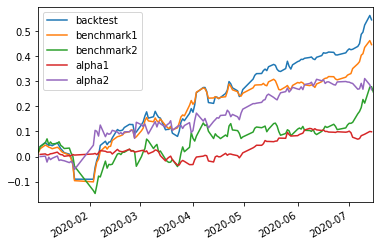

In [1031]:
#调仓周期
m = 2
y_hat = DataFrame(model.predict(df_test).values.reshape(len(test_date), len(y.columns)), index=test_date, columns=y.columns)
position = (y_hat.gt(y_hat.quantile(0.9, 1), 0))

ror_test = ror.loc[test_date, :]
r_rinei_test = r_rinei.loc[test_date, :]
r_geye_test = r_geye.loc[test_date, :]

ror_huice = position * (ror_test.rolling(m).sum().shift(-m+1) - r_geye_test) / m
ror_huice[ror_huice==0] = np.nan
ror_huice.mean(1).cumsum().plot()

benchmark1 = (ror_test.rolling(m).sum().shift(-m+1) - r_geye_test) / m
benchmark1.mean(1).cumsum().plot()
benchmark2 = ror_test
benchmark2.mean(1).cumsum().plot()

alpha1 = ror_huice.mean(1).cumsum() - benchmark1.mean(1).cumsum()
alpha2 = ror_huice.mean(1).cumsum() - benchmark2.mean(1).cumsum()
alpha1.plot()
alpha2.plot()
#for i in industry:
#    stock = industrys[i]
#    ror_test.loc[:,stock].mean(1).cumsum().plot()
plt.legend(['backtest', 'benchmark1', 'benchmark2', 'alpha1', 'alpha2'] + [i for i in industry])
print(y_hat.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

In [883]:
position.sum(1)

2018-01-02    0
2018-01-03    7
2018-01-04    7
2018-01-05    7
2018-01-08    7
             ..
2020-07-09    7
2020-07-10    7
2020-07-13    7
2020-07-14    7
2020-07-15    7
Length: 615, dtype: int64

In [884]:
df_y_test2 = DataFrame({'y':y.loc[test_date, :].values.flatten()})
df_x_test2 = DataFrame({k:factor[k].loc[test_date, :].values.flatten() for k in factor.keys()})
df_test2 = pd.concat([df_y_test2, df_x_test2], axis=1)
y_hat2 = DataFrame(model.predict(df_test2).values.reshape(len(ror_test), len(ror_test.columns)), index=ror_test.index, columns=ror_test.columns)
print(y_hat2.iloc[-1,:].sort_values(ascending=False).dropna().iloc[:10])

603363.SH    0.113558
300829.SZ    0.089692
002852.SZ    0.088179
600540.SH    0.075239
603668.SH    0.072485
000592.SZ    0.068906
600195.SH    0.068519
600467.SH    0.068034
000798.SZ    0.054606
300087.SZ    0.053120
Name: 2020-07-15 00:00:00, dtype: float64


In [465]:
df_train = df_train.dropna()
model = RandomForestRegressor(n_estimators=10).fit(df_train.iloc[:, 1:], df_train.iloc[:, 0])
model.feature_importances_

array([0.05159753, 0.05007378, 0.04443164, 0.04619165, 0.04480049,
       0.04128151, 0.04127881, 0.05454827, 0.05270984, 0.05264996,
       0.04963717, 0.05406033, 0.04655707, 0.04854932, 0.0502602 ,
       0.0494474 , 0.04531465, 0.04479211, 0.04590302, 0.0421521 ,
       0.04376315])